In [866]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import joblib
import pickle

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score

In [867]:


def get_metrics(y_test, y_pred):
    predicted_for_discharge = list(np.where(y_pred == False)[0])
    wrongful_discharge = y_test.reset_index(drop=True)[predicted_for_discharge].sum()/len(predicted_for_discharge)
    print(f"WRONGFUL DISCHARGE RATE: {wrongful_discharge}")

    print(f"F1_SCORE: {f1_score(y_test, y_pred)}")
    print(f"RECALL: {recall_score(y_test, y_pred)}")
    print(f"PRECISION: {precision_score(y_test, y_pred)}")

    

    try:
        print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
    except: "ROC AUC curve could not be calculated"


In [868]:
#data = pd.read_csv("data/cleaned_data_add_features.csv")
data = pd.read_csv("data/cleaned_data.csv")

#data = pd.read_csv("data/train_data.csv")
#data.readmitted = data.readmitted.replace(["Yes", "No"], [True, False])
#data[categorical_features] =  data[categorical_features].astype(str)
#data = data[~data["discharge_disposition_code"].isin(["11.0", "13.0", "14.0", "19.0", "20.0", "21.0"])]

## change target value to boolean
data.readmitted = data.readmitted.replace(["Yes", "No"], [True, False])

data.head()

,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,time_in_hospital,...,blood_type,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed,readmitted
0,0,199042938,Caucasian,Male,[50-60),NaN,3.0,1.0,1.0,1,...,A+,14.5,False,None,None,No,No,No,Yes,False
1,1,91962954,Caucasian,Male,[80-90),NaN,2.0,1.0,7.0,3,...,B+,15.7,False,None,>7,No,No,No,No,True
2,3,157495374,African American,Female,[70-80),NaN,NaN,1.0,NaN,2,...,AB-,13.5,False,None,>8,No,No,No,Yes,False
3,4,82692360,Caucasian,Female,NaN,NaN,1.0,22.0,7.0,12,...,A+,13.0,False,None,None,No,No,No,No,False
4,5,218016576,Caucasian,Female,[70-80),NaN,2.0,1.0,1.0,4,...,A+,13.1,False,None,None,No,No,No,Yes,True


In [869]:

"""
data.age=data.age_as_int
data.discharge_disposition_code = data.discharge_disposition_simplified
data.admission_source_code = data.admission_source_simplified
data.medical_specialty = data.medical_specialty_simplified
data.diag_1 = data.diag_1_simplified
data.diag_2 = data.diag_2_simplified
data.diag_3 = data.diag_3_simplified
"""




'\ndata.age=data.age_as_int\ndata.discharge_disposition_code = data.discharge_disposition_simplified\ndata.admission_source_code = data.admission_source_simplified\ndata.medical_specialty = data.medical_specialty_simplified\ndata.diag_1 = data.diag_1_simplified\ndata.diag_2 = data.diag_2_simplified\ndata.diag_3 = data.diag_3_simplified\n'

In [870]:
data.columns[-7:]

Index(['max_glu_serum', 'A1Cresult', 'diuretics', 'insulin', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')

In [871]:
#dummy model: predicting everything as true
get_metrics(data.readmitted, [True]*len(data))

WRONGFUL DISCHARGE RATE: nan
F1_SCORE: 0.20393259701086341
RECALL: 1.0
PRECISION: 0.11354395535015278
ROC AUC: 0.5


In [872]:
#dummy model2 - predict same rate of readmission as in dataset
predict_same_rate = data.readmitted.sample(frac=1).reset_index(drop=True)
get_metrics(data.readmitted, predict_same_rate)

WRONGFUL DISCHARGE RATE: 0.11340132759750435
F1_SCORE: 0.11465747330960854
RECALL: 0.11465747330960854
PRECISION: 0.11465747330960854
ROC AUC: 0.5006280728560522


In [873]:
def diagnosis_decoder(code):
    if "V" in str(code): 
        return "External causes of injury and supplemental classification"
    elif "E" in str(code):
        return "External causes of injury and supplemental classification"
    else:
        try:
        
            code = int(code)
            if code<140: return "infectious and parasitic diseases"
            if code<240: return "neoplasms"
            if code<280: return "endocrine, nutritional and metabolic diseases, and immunity disorders"
            if code<290: return "diseases of the blood and blood-forming organs"
            if code<320: return "mental disorders"
            if code<390: return "diseases of the nervous system and sense organs"
            if code<460: return "diseases of the circulatory system"
            if code<520: return "diseases of the respiratory system"
            if code<580: return "diseases of the digestive system"
            if code<630: return "diseases of the genitourinary system"
            if code<680: return "complications of pregnancy, childbirth, and the puerperium"
            if code<710: return "diseases of the skin and subcutaneous tissue"
            if code<740: return "diseases of the musculoskeletal system and connective tissue"
            if code<760: return "congenital anomalies"
            if code<780: return "certain conditions originating in the perinatal period"
            if code<800: return "symptoms, signs, and ill-defined conditions"
            if code<1000: return "injury and poisoning"
        except:
            return(np.nan)
        




#### Feature engineering

In [874]:
#code age groups as integers
data["age_as_int"] = data.age.replace(['[50-60)', '[80-90)', '[60-70)', '[70-80)', '[40-50)', '[30-40)',
 '[90-100)', '[20-30)', '[10-20)', '[0-10)'], [50, 80, 60, 70, 40, 30, 90, 20, 10, 0])


In [875]:
#is patient insured
payer_codes = list(data.payer_code.dropna().unique())
payer_codes.remove("SP")

data["isInsured"] = data.payer_code.replace(list(payer_codes), True)
data["isInsured"] = data.isInsured.replace("SP", False)
data["isInsured"].unique()


array([nan, True, False], dtype=object)

In [876]:
payer_codes

['MC',
 'HM',
 'BC',
 'MD',
 'PO',
 'OG',
 'CP',
 'CM',
 'DM',
 'UN',
 'SI',
 'CH',
 'OT',
 'WC',
 'MP',
 'FR']

In [877]:
def filter_common_categories(data, column_name, threshold):
    common_categories = list(data[column_name].value_counts()[data[column_name].value_counts()>threshold].index.values)
    common_categories.append(np.nan)
    data[column_name] = np.where(data[column_name].isin(common_categories), data[column_name], 'Other')
    data[column_name] = data[column_name].replace("nan", np.nan)
    return common_categories



In [878]:
#keep only common values for payer_code, set others as "Other"
column_name = "payer_code"
threshold=100
filter_common_categories(data, column_name, threshold)
#data[column_name].unique()

['MC',
 'HM',
 'SP',
 'BC',
 'MD',
 'CP',
 'UN',
 'CM',
 'OG',
 'PO',
 'DM',
 'CH',
 'WC',
 nan]

In [879]:
#keep only common values for admission_type_code, set others as "Other"
column_name = "admission_type_code"
threshold=100
filter_common_categories(data, column_name, threshold)
#data[column_name].unique()

[1.0, 3.0, 2.0, nan]

In [880]:
#keep only common values for discharge disposition, set others as "Other"
column_name = "discharge_disposition_code"
threshold=100
filter_common_categories(data, column_name, threshold)
#data[column_name].unique()

[1.0, 3.0, 6.0, 2.0, 22.0, 5.0, 4.0, 7.0, 23.0, 28.0, nan]

In [881]:
#keep only common values for admission_source_code, set others as "Other"
column_name = "admission_source_code"
threshold=100
filter_common_categories(data, column_name, threshold)
#data[column_name].unique()

[7.0, 1.0, 4.0, 6.0, 2.0, 5.0, 3.0, nan]

In [882]:
#keep only common values for medical_specialty set others as "Other"
column_name = "medical_specialty"
threshold=100
filter_common_categories(data, column_name, threshold)
#data[column_name].unique()

['InternalMedicine',
 'Emergency/Trauma',
 'Family/GeneralPractice',
 'Cardiology',
 'Surgery-General',
 'Nephrology',
 'Orthopedics',
 'Orthopedics-Reconstructive',
 'Radiologist',
 'Pulmonology',
 'Psychiatry',
 'Urology',
 'ObstetricsandGynecology',
 'Surgery-Cardiovascular/Thoracic',
 'Gastroenterology',
 'Surgery-Vascular',
 'Surgery-Neuro',
 'PhysicalMedicineandRehabilitation',
 'Oncology',
 'Pediatrics',
 'Neurology',
 'Hematology/Oncology',
 'Pediatrics-Endocrinology',
 'Otolaryngology',
 nan]

In [883]:
#simplify diagnosis codes
diag_columns = ['diag_1','diag_2','diag_3']
for col in diag_columns:
    data[f"{col}_simplified"] = data[col].str.replace(r"\.(.*)", "")  #remove any numbers that come after .
    #df_copy[col].str.replace('E','-')
    #df_copy[col] = df_copy[col].str.replace('V','-')
    data[f"{col}_simplified"] = data.apply(lambda row: diagnosis_decoder(row[f"{col}_simplified"]),axis=1)




In [884]:
data = data.drop(["admission_id", "patient_id", "age", "weight", "diag_1", "diag_2", "diag_3", "blood_type", "payer_code"], axis=1)

In [885]:
features_df = pd.DataFrame(list(zip((data.isnull().sum()/len(data)*100).values, data.nunique().values, data.dtypes.values)),  
    columns=["% of missing values", "Number of unique values", "Data type"], index=data.columns).drop("readmitted")

In [886]:
features_df

,% of missing values,Number of unique values,Data type
race,2.265323,5,object
gender,0.002525,2,object
admission_type_code,11.508448,4,object
discharge_disposition_code,5.381721,11,object
admission_source_code,6.907089,8,object
time_in_hospital,0.000000,14,int64
medical_specialty,49.042857,25,object
has_prosthesis,0.000000,2,bool
complete_vaccination_status,0.000000,3,object
num_lab_procedures,1.833472,115,float64


In [887]:
target = "readmitted"

all_features = list(features_df.index)
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['O', 'bool']).drop(["readmitted"], axis=1).columns

data[numerical_features] = data[numerical_features].astype(float)

In [888]:
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)

df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [889]:
df_train.dtypes

race                            object
gender                          object
admission_type_code             object
discharge_disposition_code      object
admission_source_code           object
time_in_hospital               float64
medical_specialty               object
has_prosthesis                    bool
complete_vaccination_status     object
num_lab_procedures             float64
num_procedures                 float64
num_medications                float64
number_outpatient              float64
number_emergency               float64
number_inpatient               float64
number_diagnoses               float64
hemoglobin_level               float64
blood_transfusion                 bool
max_glu_serum                   object
A1Cresult                       object
diuretics                       object
insulin                         object
change                          object
diabetesMed                     object
readmitted                        bool
age_as_int               

In [890]:
classifiers = [
    LogisticRegression(random_state=42, n_jobs=-1),
    RandomForestClassifier(random_state=42, n_jobs=-1),
    SVC(random_state=42, probability=True),
    GradientBoostingClassifier(random_state=42)
    
]

parameters = [
              {"C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], "penalty": ['none', 'l1', 'l2', 'elasticnet'], "solver": ['newton-cg', 'lbfgs', 'liblinear']},

              {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [1,4,5,6,7,8], 'criterion' :['gini', 'entropy']},


              {'kernel':('linear', 'rbf'), 'C':[1, 10]},

              {
              "loss":["deviance"],
            "learning_rate": [0.01, 0.05, 0.1, 0.2, 1], "min_samples_split": [0.1, 0.25, 0.5],
    "max_depth":[1],
    "max_features":["log2","sqrt"],
    "n_estimators":[100]}

                

              
             ]

In [891]:
# Write code to train and serialize a model in the block below
#
# Outputs expected: `columns.json`, `dtypes.pickle` and `pipeline.pickle`
#
# Your pipeline should be able to receive a dataframe with the columns we've requested you to use
# in the form `pipeline.predict(test_df)`
#



def define_pipeline(classifier, params):







    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)])



    pipeline = make_pipeline(
        preprocessor,
        #LogisticRegression(random_state=42, n_jobs=-1),
        #RandomForestClassifier(max_depth=100, min_samples_leaf=.003, random_state=42, n_jobs=-1),
        #GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0, max_depth=1, random_state=42, n_jobs=-1)
        #SVC(probability=True, random_state=42, n_jobs=-1)
        GridSearchCV(classifier,
                    param_grid=params,
                    cv=2, scoring="f1",
                    refit=True)

    )


    return pipeline






In [892]:
X_train = df_train[all_features]
y_train = df_train[target]


# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)


# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X_train, y_train)


In [893]:
#pipeline.fit(X_train, y_train)
#pipeline.fit(X_over, y_over)
#pipeline.fit(X_under, y_under)

LogisticRegression(n_jobs=-1, random_state=42)
{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
WRONGFUL DISCHARGE RATE: 0.07626282557221783
F1_SCORE: 0.26868065766608745
RECALL: 0.5652418447694039
PRECISION: 0.17622304050499737
ROC AUC: 0.6155631028839552


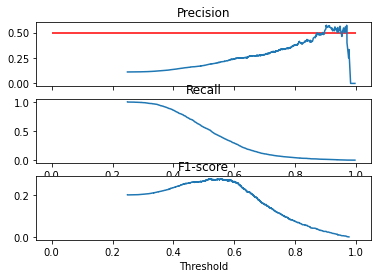

In [894]:
best_params = []
preds_probas = []
for classifier, params in zip(classifiers[0:1], parameters[0:1]):
    pipeline = define_pipeline(classifier, params)

    print(classifier)
    pipeline.fit(X_under, y_under)

    print(pipeline.named_steps['gridsearchcv'].best_params_)
    #make predictions
    X_val = df_val[all_features]

    y_val = df_val[target]

    y_pred = pipeline.predict(X_val)
    preds_proba = pipeline.predict_proba(X_val)[:, 1]

    get_metrics(y_val, y_pred)
    
    best_params.append(pipeline.named_steps['gridsearchcv'].best_params_)
    preds_probas.append(preds_proba)

    precision, recall, thresholds = precision_recall_curve(y_val, preds_proba)

    precision = precision[:-1]
    recall = recall[:-1]
    f1_score_result = 2*precision*recall/(precision+recall)



    fig=plt.figure()
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(312)
    ax3 = plt.subplot(313)

    ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
    ax1.plot(thresholds,precision)
    ax2.plot(thresholds,recall)
    ax3.plot(thresholds,f1_score_result)

    ax1.get_shared_x_axes().join(ax1, ax2, ax3)
    ax1.set_xticklabels([])
    plt.xlabel('Threshold')
    ax1.set_title('Precision')
    ax2.set_title('Recall')
    ax3.set_title('F1-score')

    plt.show()


In [895]:
#make predictions
X_val = df_val[all_features]

y_val = df_val[target]

y_pred = pipeline.predict(X_val)
preds_proba = pipeline.predict_proba(X_val)[:, 1]

# To use on other cells
X_train_baseline = X_train.copy()
X_val_baseline = df_val.copy()
y_val_baseline = X_val_baseline[target].copy()
y_pred_baseline = y_pred.copy()
pipeline_baseline = pipeline

In [896]:
get_metrics(y_val, y_pred)

WRONGFUL DISCHARGE RATE: 0.07626282557221783
F1_SCORE: 0.26868065766608745
RECALL: 0.5652418447694039
PRECISION: 0.17622304050499737
ROC AUC: 0.6155631028839552


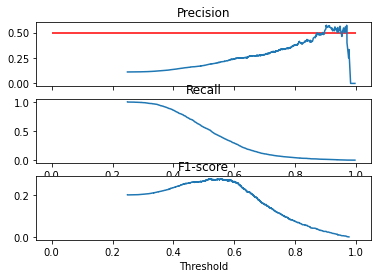

In [897]:
precision, recall, thresholds = precision_recall_curve(y_val, preds_proba)

precision = precision[:-1]
recall = recall[:-1]
f1_score_result = 2*precision*recall/(precision+recall)



fig=plt.figure()
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax3.plot(thresholds,f1_score_result)

ax1.get_shared_x_axes().join(ax1, ax2, ax3)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
ax3.set_title('F1-score')

plt.show()

In [898]:
threshold = 0.6
best_preds = preds_proba>threshold
get_metrics(y_val, best_preds)



WRONGFUL DISCHARGE RATE: 0.09177330895795247
F1_SCORE: 0.2653475393201421
RECALL: 0.2941507311586052
PRECISION: 0.24168207024029575
ROC AUC: 0.5887224746042653


In [899]:
#make predictions
X_test = df_test[all_features]

y_test = df_test[target]

y_pred_test = pipeline.predict(X_test)
preds_proba_test = pipeline.predict_proba(X_test)[:, 1]





In [900]:
best_preds_test = preds_proba_test>threshold
get_metrics(y_test, best_preds_test)


WRONGFUL DISCHARGE RATE: 0.09650849187258546
F1_SCORE: 0.2566438876233865
RECALL: 0.2768978700163845
PRECISION: 0.23915094339622642
ROC AUC: 0.5808746917186434


In [901]:
def check_for_bias(df_test, column_name, pipeline):
    df = df_test.copy().dropna()

    for sub_group in df[column_name].unique():
        df_subgroup = df[df[column_name] == sub_group]
        X_test = df_subgroup[all_features]
        y_test = df_subgroup[target]
        #y_pred_test = pipeline.predict(X_test)
        preds_proba_test = pipeline.predict_proba(X_test)[:, 1]
        best_preds_test = preds_proba_test>threshold

        

        print("######")
        print(column_name, sub_group, len(df_subgroup))
        print("######")
        get_metrics(y_test, best_preds_test)
        print("######")

            


In [902]:

#predicted_for_discharge

In [903]:
check_for_bias(df_test.append(df_val), "race", pipeline)

######
race Caucasian 5326
######
WRONGFUL DISCHARGE RATE: 0.08570198105081826
F1_SCORE: 0.26226870474658087
RECALL: 0.2905525846702317
PRECISION: 0.23900293255131966
ROC AUC: 0.5908166910759344
######
######
race African American 1466
######
WRONGFUL DISCHARGE RATE: 0.08675078864353312
F1_SCORE: 0.245014245014245
RECALL: 0.28104575163398693
PRECISION: 0.21717171717171718
ROC AUC: 0.5814977425344343
######
######
race Other 107
######
WRONGFUL DISCHARGE RATE: 0.13131313131313133
F1_SCORE: 0.1739130434782609
RECALL: 0.13333333333333333
PRECISION: 0.25
ROC AUC: 0.5340579710144927
######
######
race Asian 62
######
WRONGFUL DISCHARGE RATE: 0.037037037037037035
F1_SCORE: 0.4615384615384615
RECALL: 0.6
PRECISION: 0.375
ROC AUC: 0.756140350877193
######
######
race Hispanic 134
######
WRONGFUL DISCHARGE RATE: 0.08196721311475409
F1_SCORE: 0.5333333333333333
RECALL: 0.4444444444444444
PRECISION: 0.6666666666666666
ROC AUC: 0.7049808429118773
######


In [904]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = pipeline.steps[1][1].feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree')
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

                       Feature  Importance
2                          age    0.000000
3          admission_type_code    0.000000
0                         race    0.002747
1                       gender    0.004208
17                      diag_1    0.004920
22            hemoglobin_level    0.004965
6             time_in_hospital    0.014255
4   discharge_disposition_code    0.019667
33           diag_3_simplified    0.106128
5        admission_source_code    0.370177


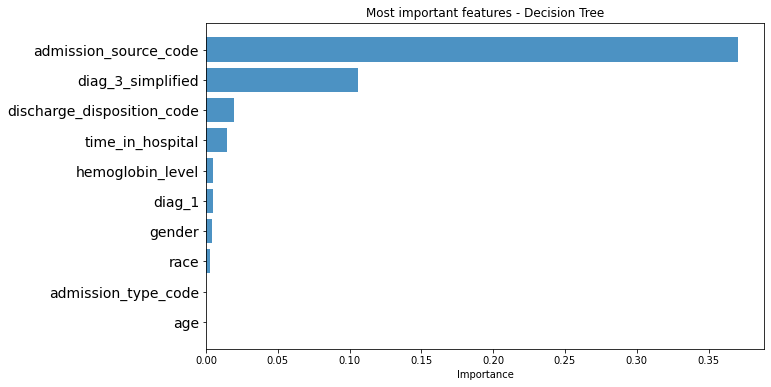

In [ ]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = pipeline.steps[1][1].feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree')
plt.show()

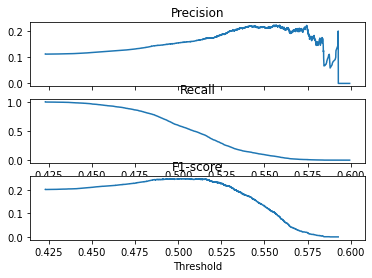

In [908]:
X_train[y_train==True]

,race,gender,admission_type_code,discharge_disposition_code,admission_source_code,time_in_hospital,medical_specialty,has_prosthesis,complete_vaccination_status,num_lab_procedures,...,A1Cresult,diuretics,insulin,change,diabetesMed,age_as_int,isInsured,diag_1_simplified,diag_2_simplified,diag_3_simplified
46861,Caucasian,Male,3.0,22.0,1.0,5.0,Orthopedics,False,Complete,32.0,...,None,No,Yes,No,Yes,70.0,True,diseases of the musculoskeletal system and con...,diseases of the circulatory system,"endocrine, nutritional and metabolic diseases,..."
35607,Caucasian,Female,NaN,1.0,NaN,2.0,Family/GeneralPractice,False,Complete,18.0,...,None,No,No,No,No,30.0,NaN,diseases of the digestive system,mental disorders,diseases of the digestive system
23557,Caucasian,Female,1.0,6.0,7.0,1.0,NaN,False,Complete,53.0,...,None,No,No,No,No,80.0,True,injury and poisoning,diseases of the circulatory system,diseases of the musculoskeletal system and con...
1427,Other,Female,1.0,2.0,1.0,5.0,Family/GeneralPractice,False,Complete,62.0,...,None,No,No,No,Yes,70.0,False,mental disorders,mental disorders,mental disorders
23050,Caucasian,Male,1.0,22.0,7.0,1.0,NaN,False,Incomplete,3.0,...,None,No,No,No,No,70.0,False,diseases of the circulatory system,diseases of the circulatory system,"endocrine, nutritional and metabolic diseases,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12407,Caucasian,Female,1.0,3.0,NaN,3.0,NaN,False,Complete,17.0,...,None,No,No,No,No,80.0,True,diseases of the digestive system,diseases of the blood and blood-forming organs,diseases of the digestive system
32894,Caucasian,Female,NaN,1.0,1.0,2.0,NaN,False,Complete,38.0,...,Norm,No,Yes,No,Yes,40.0,NaN,"endocrine, nutritional and metabolic diseases,...",diseases of the circulatory system,"endocrine, nutritional and metabolic diseases,..."
59494,Caucasian,Female,3.0,1.0,1.0,2.0,Cardiology,False,Complete,41.0,...,None,No,No,No,No,NaN,True,diseases of the circulatory system,"endocrine, nutritional and metabolic diseases,...",diseases of the circulatory system
18163,Caucasian,Male,1.0,3.0,7.0,3.0,NaN,False,Complete,55.0,...,Norm,No,Yes,No,Yes,70.0,NaN,"endocrine, nutritional and metabolic diseases,...",diseases of the circulatory system,diseases of the circulatory system


In [906]:
# Save for deployment
with open(f'columns.json', 'w') as fh:
    json.dump(X_train_baseline.columns.tolist(), fh)
    
with open(f'dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train_baseline.dtypes, fh)
    
joblib.dump(pipeline_baseline, f'pipeline.pickle')

['pipeline.pickle']